In [216]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression,LassoCV, Lasso, Ridge
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve, roc_auc_score,auc,mean_squared_error
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [68]:
import warnings
warnings.filterwarnings("ignore")

#### We will use both Compustat and CSRP to create explanatory variables
The following code has been run once in Spyder as Jupyter is very slow in loading and processing data, the results was saved in a csv and then read here to run the models

#### Loading and tidying up CSRP Daily Data

In [ ]:
path = "Q:\\Data-ReadOnly\\CRSP\\"
cols_from_csrp = ["DATE","CUSIP","PERMNO","SHRCD","RET","PRC","SHROUT"]
csrp_daily=pd.read_csv(path+"dsf_new.csv",usecols = cols_from_csrp)
csrp_daily = dsf
csrp_daily['RET']= pd.to_numeric(csrp_daily.RET, errors='coerce')
csrp_daily['PRC'] = abs(csrp_daily.PRC)
csrp_daily = csrp_daily[csrp_daily.SHRCD.isin([10, 11])]
csrp_daily=csrp_daily.drop("SHRCD",axis=1)
csrp_daily['CUSIP'] = csrp_daily['CUSIP'].str[0:6]
csrp_daily['DATE'] =pd.to_datetime(csrp_daily.DATE,format="%Y%m%d")
csrp_daily['YEAR'] = pd.DatetimeIndex(csrp_daily['DATE']).year
csrp_daily['Market_Cap'] = csrp_daily.PRC*csrp_daily.SHROUT

vol = (csrp_daily.groupby(by=['CUSIP','PERMNO','YEAR'])['RET'].std()*np.sqrt(250)).to_frame().reset_index()
vol.columns = ['CUSIP','PERMNO','YEAR','sigmaE']
vol.head()

annual_ret = csrp_daily.groupby(by=['CUSIP','PERMNO','YEAR']).apply(lambda x:np.exp(np.sum(np.log(1+x['RET'])))).to_frame().reset_index()
annual_ret.columns = ['CUSIP','PERMNO','YEAR','RET']

market_cap = csrp_daily.groupby(by=['CUSIP','PERMNO','YEAR'])['Market_Cap'].first().to_frame().reset_index()
market_cap.columns = ['CUSIP','PERMNO','YEAR','Market_Cap']
market_cap.head()

csrp_annual = vol.merge(annual_ret,how='inner',on=['CUSIP','PERMNO','YEAR']).merge(market_cap,how='inner',on=['CUSIP','PERMNO','YEAR'])
del vol
del annual_ret
del market_cap

funda_data,meta = pd.read_sas(path+"Assignment_4/funda.sas7bdat",usecols=comp_cols)
funda_data['CUSIP'] = funda_data['cusip'].str[0:6]
funda_data['DLC'] = funda_data['dlc'] * 1000000
funda_data['DLTT'] = funda_data['dltt'] * 1000000
funda_data = funda_data[(funda_data.indfmt == 'INDL') & (funda_data.datafmt == 'STD') & (funda_data.popsrc == 'D') & (funda_data.fic == 'USA') & (funda_data.consol == 'C')]
funda_data['F'] = funda_data['DLC'] + 0.5*funda_data['DLTT']
funda_data.head()

funda_data['Profitability'] = funda_data['ni']/funda_data['at']
funda_data['Profitability'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['Tangibility'] = funda_data['ppent']/funda_data['at']
funda_data['Tangibility'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['Intangibility'] = funda_data['intan']/funda_data['at']
funda_data['Intangibility'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['M2BRatio'] = funda_data['mkvalt']/funda_data['at']
funda_data['M2BRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['Debt2AssetRatio'] = funda_data['lt']/funda_data['at']
funda_data['Debt2AssetRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['CurrentRatio'] = funda_data['lct']/funda_data['act']
funda_data['CurrentRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)`

funda_data['Interest_burden'] = (funda_data['oiadp']-funda_data['xint'])/funda_data['oiadp']
final_data['Interest_burden'] = final_data['Int_burden']/final_data['at']
funda_data['Interest_burden'].replace([np.inf, -np.inf], np.nan, inplace=True)

funda_data['Leverage'] = funda_data['lct']/funda_data['at']
funda_data['Leverage'].replace([np.inf, -np.inf], np.nan, inplace=True)

final_data['Working_Cap'] = final_data['wcapc']/final_data['at']
funda_data['Working_Cap'].replace([np.inf, -np.inf], np.nan, inplace=True)

fred_baaffm = pd.read_csv(path+'BAAFFM.csv', header = 0)

fred_baaffm['DATE'] = pd.to_datetime(fred_baaffm['DATE'])
fred_baaffm['DATE'] = pd.DatetimeIndex(fred_baaffm['DATE']).year
fred_baaffm = (fred_baaffm.groupby(['DATE'], as_index=False).mean().groupby('DATE')['BAAFFM'].mean())
fred_baaffm = fred_baaffm.reset_index()
fred_baaffm = fred_baaffm.rename(columns= {"DATE":"fyear"})
fred_baaffm.head()

rf_daily = pd.read_csv(path+"DTB3.csv")

rf_daily.columns = rf_daily.columns.str.strip().str.lower()
rf_daily["date"] = pd.to_datetime(rf_daily["date"])
rf_daily["dtb3"] = pd.to_numeric(rf_daily["dtb3"], errors='coerce')
rf_daily = rf_daily.dropna(subset = ["date","dtb3"]).reset_index(drop = True)
rf_daily["fyear"] = rf_daily["date"].dt.year
rf_daily["r"] = np.log(1+rf_daily["dtb3"]/100.0) 
rf_yearly = rf_daily.groupby(by = "fyear")["r"].first()

funda_data = funda_data.merge(fred_baaffm,how='inner',on=['fyear']).merge(rf_daily,how='inner',on=['fyear'])

funda_data = funda_data[["FYEAR","CUSIP","Market_Cap","vol","rf","BAAFFM","Profitability","Tangibility","Intangibility",
                         "M2BRatio","Debt2AssetRatio","CurrentRatio","Working_Cap","Leverage"]]
funda_data['fyear'] = pd.to_numeric(funda_data.YEAR)

bankruptcy_data = pd.read_csv("BR1964_2019.csv")
bankruptcy_data['YEAR'] = pd.DatetimeIndex(bankruptcy_data['bankruptcy_dt']).year
bankruptcy_data['Bankruptcy'] = 1
bankruptcy_data = bankruptcy_data.dropna().drop(columns = ['bankruptcy_dt'])
bankruptcy_data['YEAR']= bankruptcy_data['YEAR']-1
bankruptcy_data.head()

funda_data['YEAR'] = funda_data['fyear']
data_to_train = csrp_annual.merge(funda_data,how='inner',on=['CUSIP','YEAR'])
data_to_train['YEAR']= data_to_train.groupby(by=['CUSIP','PERMNO']).YEAR.shift(-1)
data_to_train = data_to_train.merge(br_data,how='left',on=['PERMNO','YEAR'])
data_to_train['Bankruptcy'] = data_to_train.Bankruptcy.fillna(0)
data_to_train.dropna(how='all', axis=1, inplace=True)


data_to_train.to_csv(path+"data_to_train2.csv",index=False)

Saving the dataset so that we don't have to process all of these again

In [80]:
def plot_matrix_and_print_metrics(y_test, pred_test):    
    
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    plt.figure(figsize=(4,4)) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 12}, fmt='g',cmap='Reds')
    
    print("Accuracy:", metrics.accuracy_score(y_test, pred_test))
    print("Precision:", metrics.precision_score(y_test, pred_test))
    print("ROC score:", metrics.roc_auc_score(y_test, pred_test))

In [109]:
data_to_train = pd.read_csv('C:\\Users\\mvyas32\\Downloads\\data_to_train.csv', header = 0)
data_to_train.set_index("Unnamed: 0", inplace=True)
data_to_train.head()

,YEAR,CUSIP,RET,Market_Cap,vol,rf,BAAFFM,Profitability,Tangibility,Intangibility,M2BRatio,Debt2AssetRatio,CurrentRatio,Leverage,Bankruptcy
Unnamed: 0,,,,,,,,,,,,,,,
0,1965,19519,1.374766,1.908501e+08,0.146066,0.034691,1.331667,0.042877377,0.188402,0.0,NaN,0.458317,0.305254,0.304852,0
1,1965,19645,1.284818,1.731587e+08,0.257583,0.034691,1.331667,0.023066756,0.213418,0.0,0.008626,0.455545,0.367455,0.329088,0
2,1965,02376R,1.330491,3.670997e+08,0.263749,0.034691,1.331667,0.046394176,0.670889,0.0,13.285097,0.738711,0.613548,0.621773,0
3,1965,24375,1.107488,3.020528e+07,0.193071,0.034691,1.331667,0.069207317,0.362805,0.0,NaN,NaN,0.323529,NaN,0
4,1965,29609,1.181918,7.046696e+06,0.282748,0.034691,1.331667,0.026141304,0.413043,0.0,NaN,0.389946,0.673267,0.161521,0


In [110]:
data_to_train['CurrentRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [111]:
data_to_train = data_to_train.dropna()
data_to_train.describe()

,YEAR,RET,Market_Cap,vol,rf,BAAFFM,Tangibility,Intangibility,M2BRatio,Debt2AssetRatio,CurrentRatio,Leverage,Bankruptcy
count,13317.000000,13317.000000,1.331700e+04,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000
mean,1997.563640,1.202376,5.752819e+08,0.755911,0.043444,3.389351,0.332518,0.109942,2.541472,0.633854,0.979653,0.461607,0.052489
std,10.432864,3.690694,2.755122e+09,0.519512,0.024515,1.627154,0.249345,0.203027,8.045049,0.903193,4.705832,3.670210,0.223020
min,1965.000000,0.000064,3.193483e+05,0.045829,0.000200,-1.005833,0.000000,-0.005174,0.000008,0.000000,0.000000,-152.283784,0.000000
25%,1992.000000,0.558135,2.567167e+07,0.422475,0.029850,2.255833,0.123942,0.000000,0.288276,0.373470,0.348958,0.111604,0.000000
50%,1999.000000,0.919127,8.280920e+07,0.630311,0.048504,2.968333,0.272685,0.019085,0.738663,0.571839,0.550242,0.391144,0.000000
75%,2004.000000,1.320752,3.050202e+08,0.935515,0.054015,4.765000,0.499803,0.138636,1.953134,0.762007,0.872673,0.634392,0.000000
max,2020.000000,215.112829,1.550000e+11,12.960526,0.136714,7.135833,0.991953,4.713805,289.962500,74.933875,383.581395,247.847015,1.000000


In [143]:
features = ['RET','Market_Cap' ,'vol', 'rf', 'BAAFFM' , 'Profitability', 'Tangibility','M2BRatio', 'Debt2AssetRatio','CurrentRatio','Leverage']
target = ['Bankruptcy']
some = data_to_train.copy()

In [114]:
X_train = some[features]
Y_train = np.ravel(some[target])

### Training Logistic Model and Insample Testing

In [116]:
X_train = some[features]
Y_train = np.ravel(some[target])
Y_train = Y_train.reshape(-1,1)
model = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter = 100)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

Accuracy: 0.7648118945708493
Precision: 0.15703411333521286
ROC score: 0.7799447890029707


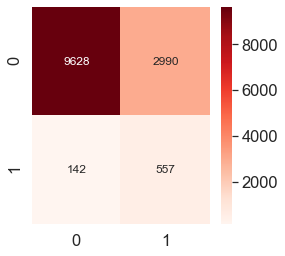

In [117]:
plot_matrix_and_print_metrics(Y_train,Y_pred)

#### Out of Sample Results

In [125]:
train = data_to_train.copy()
test = data_to_train.copy()
out_of_sample_train = train[train.YEAR.between(1964, 1990)]
out_of_sample_test = test[test.YEAR.between(1990, 2020)]

In [132]:
X_train = out_of_sample_train[features]
X_test = out_of_sample_test[features]
Y_train = out_of_sample_train[target]
Y_test = out_of_sample_test[target]

model = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter = 100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

Accuracy: 0.7780132694434205
Precision: 0.17578710644677661
ROC score: 0.7372806124155208


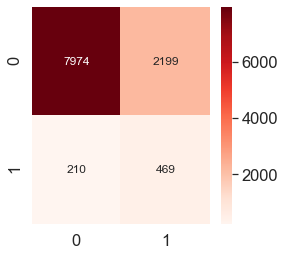

In [133]:
plot_matrix_and_print_metrics(Y_test,Y_pred)

### Lasso Regression

In [160]:
train = data_to_train.copy()
test = data_to_train.copy()
out_of_sample_train = train[train.YEAR.between(1964, 1990)]
out_of_sample_test = test[test.YEAR.between(1990, 2020)]
X_train = out_of_sample_train[features]
X_test = out_of_sample_test[features]
Y_train = out_of_sample_train[target]
Y_test = out_of_sample_test[target]

In [161]:
model = Lasso(alpha = 0.0005).fit(X_train, Y_train)
score = model.score(X_train, Y_train)
y_predicted = model.predict(X_test)

In [142]:
coefficients = model.coef_
importance = np.abs(coefficients)
importance

array([2.09674161e-03, 7.77755184e-13, 0.00000000e+00, 0.00000000e+00,
       9.61893783e-04, 3.62931425e-02, 0.00000000e+00, 2.46800474e-04,
       1.54700206e-02, 4.23869036e-04, 1.67468286e-02])

In [145]:
new_features = ['RET', 'Profitability', 'BAAFFM', 'CurrentRatio', 'M2BRatio', 'Debt2AssetRatio',
       'Leverage']

Accuracy: 0.9367858459270181
Precision: 0.3157894736842105
ROC score: 0.5037793159200036


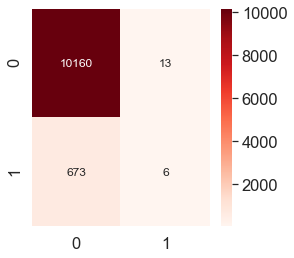

In [167]:
X_train = out_of_sample_train[new_features]
X_test = out_of_sample_test[new_features]
model = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter = 100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
plot_matrix_and_print_metrics(Y_test,ypred)

### Ridge Regresssion

In [169]:
train = data_to_train.copy()
test = data_to_train.copy()
out_of_sample_train = train[train.YEAR.between(1964, 1990)]
out_of_sample_test = test[test.YEAR.between(1990, 2020)]
X_train = out_of_sample_train[features]
X_test = out_of_sample_test[features]
Y_train = out_of_sample_train[target]
Y_test = out_of_sample_test[target]

In [170]:
model = Ridge(alpha = 50).fit(X_train, Y_train)

In [171]:
score = model.score(X_train, Y_train)
y_predicted = model.predict(X_test)

Text(0.5, 1.0, 'Feature Coefficients')

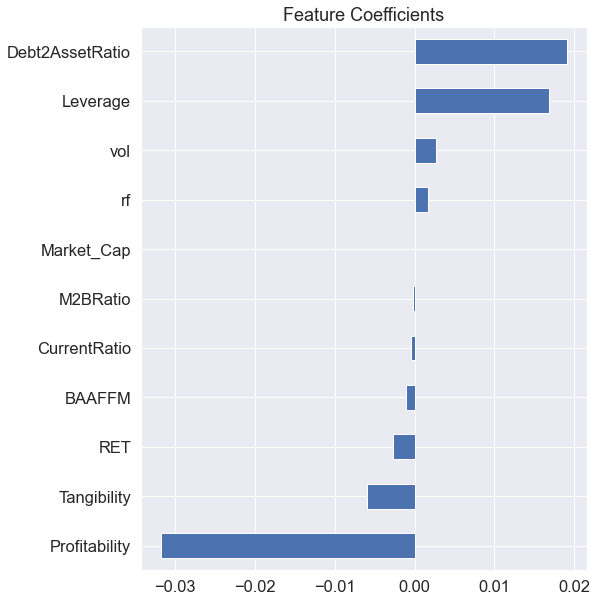

In [172]:
coef = pd.Series(model.coef_[0], index = X_train.columns)
imp_coef = coef.sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature Coefficients")

In [174]:
coefficients = model.coef_
coeffs = np.abs(coefficients)
coeffs

array([[2.75296565e-03, 9.95441044e-13, 2.74185277e-03, 1.62460604e-03,
        1.07514068e-03, 3.17329326e-02, 5.91278728e-03, 2.37486226e-04,
        1.90601374e-02, 4.33495405e-04, 1.68099032e-02]])

In [190]:
new_features = ['RET' ,'vol', 'rf', 'BAAFFM' , 'Profitability', 'Tangibility', 'Debt2AssetRatio','CurrentRatio','Leverage']

Accuracy: 0.9367858459270181
Precision: 0.3157894736842105
ROC score: 0.5037793159200036


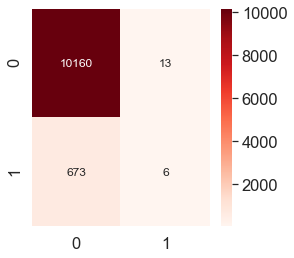

In [191]:
X_train = out_of_sample_train[new_features]
X_test = out_of_sample_test[new_features]
model = LogisticRegression(solver='newton-cg', class_weight='balanced', max_iter = 100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
plot_matrix_and_print_metrics(Y_test,ypred)

### K nearest neighbours

In [182]:
train = data_to_train.copy()
test = data_to_train.copy()
out_of_sample_train = train[train.YEAR.between(1964, 1990)]
out_of_sample_test = test[test.YEAR.between(1990, 2020)]
X_train = out_of_sample_train[features]
X_test = out_of_sample_test[features]
Y_train = out_of_sample_train[target]
Y_test = out_of_sample_test[target]

In [185]:
k_range = range(1, 10)
all_results = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    all_results.append(metrics.accuracy_score(Y_test, y_pred))

Text(0, 0.5, 'Accuracy')

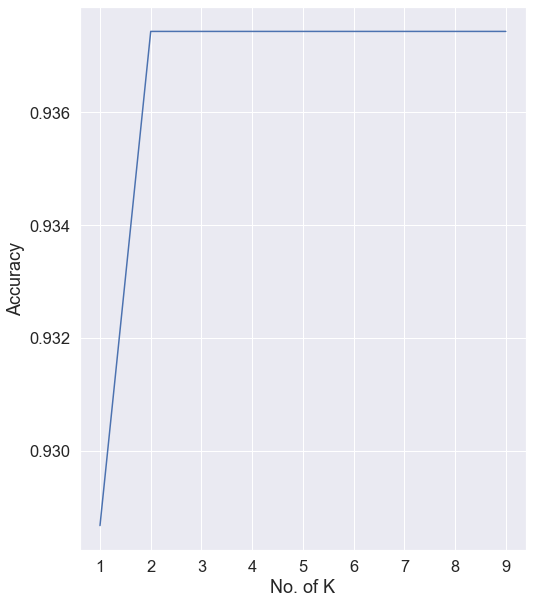

In [188]:
plt.plot(k_range, all_results)
plt.xlabel("No. of K")
plt.ylabel("Accuracy")

In [193]:
knn_2 = KNeighborsClassifier(n_neighbors = 2)
knn_2.fit(X_train, Y_train)
y_predicted = knn_2.predict(X_test)

Accuracy: 0.9374308883155179
Precision: 0.5
ROC score: 0.5013744546300402


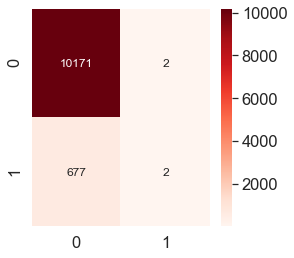

In [194]:
plot_matrix_and_print_metrics(Y_test,y_predicted)

### Random Forest Survival

In [219]:
from scikitsksurv.ensemble import RandomForestSurvival

ModuleNotFoundError: No module named 'scikitsksurv'

### Random Forest

In [211]:
train = data_to_train.copy()
test = data_to_train.copy()
out_of_sample_train = train[train.YEAR.between(1964, 1990)]
out_of_sample_test = test[test.YEAR.between(1990, 2020)]
X_train = out_of_sample_train[features]
X_test = out_of_sample_test[features]
Y_train = out_of_sample_train[target]
Y_test = out_of_sample_test[target]

In [196]:
param_grid = {'n_estimators': [200,400, 600, 1000],
               'max_depth': [5,10,20]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
rf_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [200, 400, 600, 1000]},
             verbose=2)

In [197]:
rf_grid.best_params_

{'max_depth': 5, 'n_estimators': 400}

Accuracy: 0.9367858459270181
Precision: 0.3157894736842105
ROC score: 0.5037793159200036


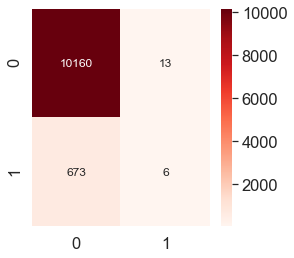

In [212]:
model = RandomForestClassifier(n_estimators = 400, random_state = 42,max_depth=5)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
plot_matrix_and_print_metrics(Y_test,ypred)

In [220]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
model = XGBClassifier()
    
param_grid = dict(n_estimators=[100,200,300])
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, Y_train)
y_pred = grid_search.predict(X_test.values)


### Articial Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
input_length = len(X_train.columns)
model = Sequential()
model.add(Dense(10, input_dim=input_length, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))